# Speech Prominence Detection

In [2]:
from matplotlib import pyplot as plt
import random
import pickle as pkl
import pandas as pd
import numpy as np
import math
from IPython.display import clear_output

In [3]:
import tensorflow as tf

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Conv1D, MaxPooling1D, MaxPooling2D, TimeDistributed, Input, Reshape, concatenate, Conv2D, Concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [6]:
# load data in one line
ger_train = pkl.load(open("../../saved/ger_train.pkl", "rb"))
ger_test = pkl.load(open("../../saved/ger_test.pkl", "rb"))

## Stressed and Unstressed Labels

In [7]:
ger_train_labels = np.array(ger_train["labels"])
ger_test_labels = np.array(ger_test["labels"])

# count 0s and 1s
zeros_train = np.count_nonzero(ger_train_labels == 0)
ones_train = np.count_nonzero(ger_train_labels == 1)

zeros_test = np.count_nonzero(ger_test_labels == 0)
ones_test = np.count_nonzero(ger_test_labels == 1)

print("Train")
print("0s: ", zeros_train)
print("1s: ", ones_train)
# percentage of 1s
print("Percentage of 1s: ", ones_train / (ones_train + zeros_train))
print("Percentage of 0s: ", zeros_train / (ones_train + zeros_train))
print()
print("Test")
print("0s: ", zeros_test)
print("1s: ", ones_test)

Train
0s:  2979
1s:  9216
Percentage of 1s:  0.7557195571955719
Percentage of 0s:  0.24428044280442804

Test
0s:  2548
1s:  8035


## Contour Lengths

In [8]:
# make a list of lengths of all contours
lengths_train = np.array([len(contour) for contour in ger_train["chunks"]])
lengths_train.mean()

lengths_test = np.array([len(contour) for contour in ger_test["contour"]])
lengths_test.mean()

print("Train")
print("max length: ", lengths_train.max())
print("min length: ", lengths_train.min())

print("mean length: ", lengths_train.mean())
print()
print("Test")
print("max length: ", lengths_test.max())
print("mean length: ", lengths_test.mean())

Train
max length:  247
min length:  3
mean length:  25.35662156621566

Test
max length:  285
mean length:  25.306812813001983


In [9]:
# calculate the max length of all contours
max_length_train = max([len(contour) for contour in ger_train["chunks"]])
max_length_test = max([len(contour) for contour in ger_test["contour"]])
max_length = max(max_length_train, max_length_test)

## Padding

In [10]:
# pad all contours to the same length using left padding, right padding, and both side padding
def pad_contours(contours, length, padding="both"):
    padded_contours = []
    for contour in contours:
        if padding == "left":
            padded_contours.append(np.pad(contour, (length-len(contour), 0), 'constant'))
        elif padding == "right":
            padded = np.pad(contour, (0, length-len(contour)), 'constant')
            padded_contours.append(padded)
        elif padding == "both":
            padded = np.pad(contour, (math.floor((length-len(contour))/2), math.ceil((length-len(contour))/2)), 'constant')
            padded_contours.append(padded)
    return np.array(padded_contours)

In [11]:
contours_train_rp = pad_contours(ger_train["chunks"], max_length, padding="right")
contours_train_lp = pad_contours(ger_train["chunks"], max_length, padding="left")
contours_train_bp = pad_contours(ger_train["chunks"], max_length, padding="both")

contours_test_rp = pad_contours(ger_test["contour"], max_length, padding="right")
contours_test_lp = pad_contours(ger_test["contour"], max_length, padding="left")
contours_test_bp = pad_contours(ger_test["contour"], max_length, padding="both")

In [12]:
contours_train_rp_df = pd.DataFrame(contours_train_rp)
contours_train_lp_df = pd.DataFrame(contours_train_lp)
contours_train_bp_df = pd.DataFrame(contours_train_bp)

right


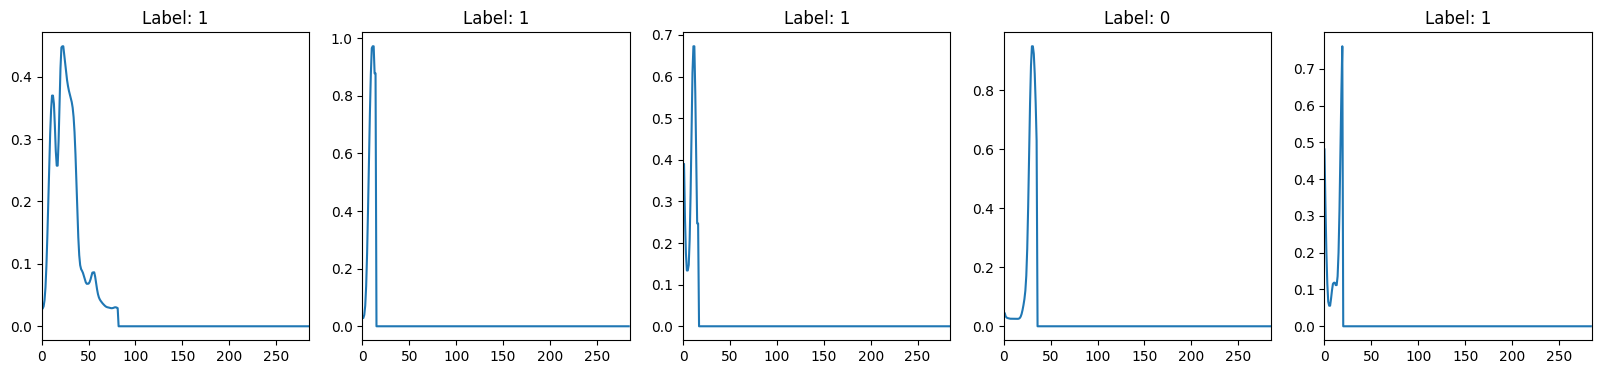

left


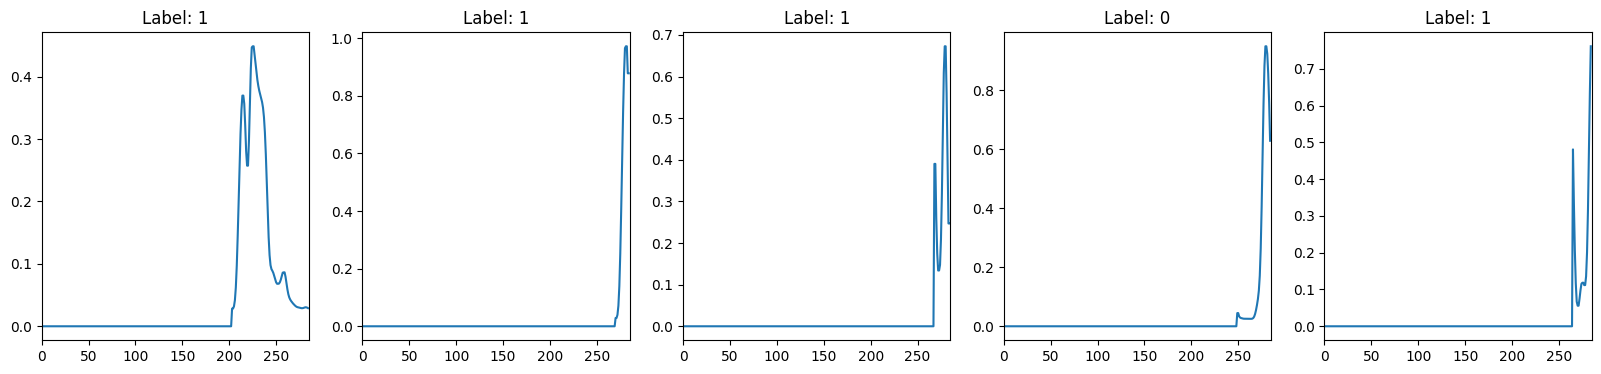

both


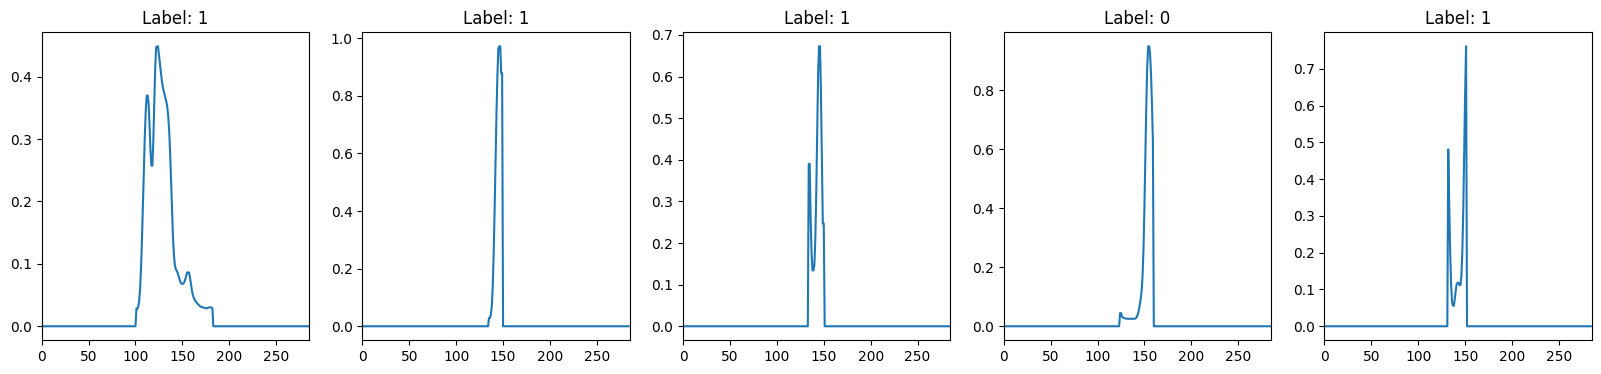

In [13]:
# visualize the padded contours side by side with subplots
def plot_contours(contours, labels, length, padding="both"):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    print(padding)

    for i in range(5):
        r = random.randint(0, len(contours)-1)
        z = i + 100
        axs[i].plot(contours[z])
        axs[i].set_title("Label: " + str(labels[z]))


        if padding == "left":
            axs[i].set_xlim(0, length)

        elif padding == "right":
            axs[i].set_xlim(0, length)

        elif padding == "both":
            axs[i].set_xlim(0, length)
    plt.show()

plot_contours(contours_train_rp, ger_train_labels, max_length, padding="right")
plot_contours(contours_train_lp, ger_train_labels, max_length, padding="left")
plot_contours(contours_train_bp, ger_train_labels, max_length, padding="both")

## Basic DNN Model

In [14]:
model = Sequential()
model.add(Dense(64, input_dim=max_length, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                18304     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 2

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(contours_train_rp, ger_train_labels, batch_size=8, epochs=40, validation_split=0.1)


Epoch 1/40


1372/1372 [==============================] - 9s 5ms/step - loss: 0.4660 - accuracy: 0.7886 - val_loss: 0.4536 - val_accuracy: 0.8164
Epoch 2/40
1372/1372 [==============================] - 7s 5ms/step - loss: 0.4312 - accuracy: 0.8116 - val_loss: 0.4211 - val_accuracy: 0.8238
Epoch 3/40
1372/1372 [==============================] - 7s 5ms/step - loss: 0.4232 - accuracy: 0.8166 - val_loss: 0.4208 - val_accuracy: 0.8279
Epoch 4/40
1372/1372 [==============================] - 7s 5ms/step - loss: 0.4104 - accuracy: 0.8214 - val_loss: 0.4075 - val_accuracy: 0.8262
Epoch 5/40
1372/1372 [==============================] - 7s 5ms/step - loss: 0.4023 - accuracy: 0.8272 - val_loss: 0.3916 - val_accuracy: 0.8320
Epoch 6/40
1372/1372 [==============================] - 7s 5ms/step - loss: 0.3945 - accuracy: 0.8282 - val_loss: 0.4098 - val_accuracy: 0.8320
Epoch 7/40
1372/1372 [==============================] - 6s 5ms/step - loss: 0.3924 - accuracy: 0.8315 - val_loss: 0.3828 - val_accura

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def results(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred = np.round(y_pred)
    y_pred = y_pred.astype(int)
    y_pred = y_pred.flatten()

    y_test = np.array(y_test)
    y_test = y_test.astype(int)

    # in percentage
    print("Accuracy: ", np.sum(y_pred == y_test)/len(y_test)*100, "%")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='g')

    return y_pred

331/331 [==============================] - 1s 2ms/step
Accuracy:  84.28611924785032 %


array([1, 1, 1, ..., 1, 1, 0])

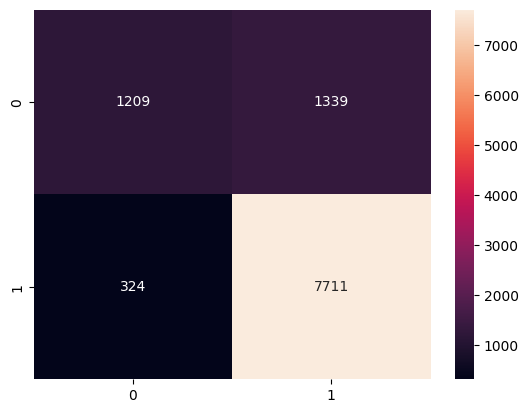

In [18]:
results(model, contours_test_rp, ger_test_labels)

# Combine the Datasets

In [19]:
# merge the train and test sets for german
contours_merged = np.concatenate((contours_train_rp, contours_test_rp), axis=0)
labels_merged = np.concatenate((ger_train_labels, ger_test_labels), axis=0)

print(contours_merged.shape)
print(labels_merged.shape)

(22778, 285)
(22778,)


In [20]:
# remove the contours whose max value is 0
contours_merged_nonzero = contours_merged[contours_merged.max(axis=1) != 0]
labels_merged_nonzero = labels_merged[contours_merged.max(axis=1) != 0]

print(contours_merged_nonzero.shape)
print(labels_merged_nonzero.shape)  

(22778, 285)
(22778,)


In [21]:
contours_merged_normalized = contours_merged_nonzero / contours_merged_nonzero.max(axis=1)[:,None]
contours_merged_nonzero.shape

(22778, 285)

In [22]:
contours_merged_normalized

array([[0.02056509, 0.02056509, 0.03322696, ..., 0.        , 0.        ,
        0.        ],
       [0.49618718, 0.49618718, 0.30855722, ..., 0.        , 0.        ,
        0.        ],
       [0.08576533, 0.08576533, 0.08576533, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.89507442, ..., 0.        , 0.        ,
        0.        ],
       [0.38546821, 0.2496948 , 0.14544928, ..., 0.        , 0.        ,
        0.        ]])

In [23]:
# do a train test split
contours_train_merged, contours_test_merged, labels_train_merged, labels_test_merged = train_test_split(contours_merged_normalized, labels_merged_nonzero, test_size=0.2, random_state=42)

In [24]:
print(contours_train_merged.shape)
print(contours_test_merged.shape)

# count 0s and 1s in the train and test sets
print("Train")
print("0s: ", np.sum(labels_train_merged == 0))
print("1s: ", np.sum(labels_train_merged == 1))

print()
print("Test")
print("0s: ", np.sum(labels_test_merged == 0))
print("1s: ", np.sum(labels_test_merged == 1))

(18222, 285)
(4556, 285)
Train
0s:  4400
1s:  13822

Test
0s:  1127
1s:  3429


In [25]:
# class weights
class_weights = compute_class_weight("balanced", classes=[0, 1], y=labels_train_merged)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:")
for label, weight in class_weights_dict.items():
    print(f"{label}:    {weight:.2f}")

Class weights:
0:    2.07
1:    0.66


In [26]:
# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [27]:
# Define the model
model = Sequential()
model.add(Dense(64, input_dim=max_length, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                18304     
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 64)               

In [28]:
# compile with adam optimizer with learning rate 0.0001
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [30]:
model.fit(
    contours_train_merged, labels_train_merged,
    batch_size=2, epochs=20, validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/20
7289/7289 [==============================] - 40s 5ms/step - loss: 0.3755 - accuracy: 0.8443 - val_loss: 0.4203 - val_accuracy: 0.8302
Epoch 2/20
7289/7289 [==============================] - 41s 6ms/step - loss: 0.3682 - accuracy: 0.8480 - val_loss: 0.3989 - val_accuracy: 0.8384
Epoch 3/20
7289/7289 [==============================] - 41s 6ms/step - loss: 0.3628 - accuracy: 0.8537 - val_loss: 0.4031 - val_accuracy: 0.8370
Epoch 4/20
7289/7289 [==============================] - 41s 6ms/step - loss: 0.3597 - accuracy: 0.8548 - val_loss: 0.3984 - val_accuracy: 0.8335
Epoch 5/20
7289/7289 [==============================] - 43s 6ms/step - loss: 0.3554 - accuracy: 0.8556 - val_loss: 0.3992 - val_accuracy: 0.8401
Epoch 6/20
7289/7289 [==============================] - 41s 6ms/step - loss: 0.3522 - accuracy: 0.8574 - val_loss: 0.3974 - val_accuracy: 0.8436
Epoch 7/20
7289/7289 [==============================] - 41s 6ms/step - loss: 0.3485 - accuracy: 0.8583 - val_loss: 0.3930 - val_ac

143/143 [==============================] - 0s 2ms/step
Accuracy:  85.35996488147498 %


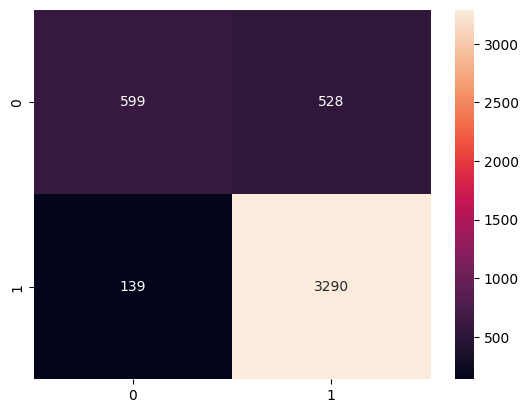

In [31]:
ans = results(model, contours_test_merged, labels_test_merged)

In [32]:
ans

array([0, 1, 0, ..., 1, 1, 1])

In [33]:
max_length

285

# Augmentation

In [34]:
ger_train

,chunks,labels
0,"[0.01659550862520646, 0.01659550862520646, 0.0...",1
1,"[0.20705475938828283, 0.20705475938828283, 0.1...",1
2,"[0.0853309212266154, 0.0853309212266154, 0.085...",1
3,"[0.017483717247693344, 0.017483717247693344, 0...",1
4,"[0.015928296040650866, 0.015928296040650866, 0...",1
...,...,...
12190,"[0.36702525527922875, 0.36702525527922875, 0.3...",1
12191,"[0.06277111831880124, 0.06277111831880124, 0.0...",1
12192,"[0.28230350823965955, 0.28230350823965955, 0.2...",1
12193,"[0.24910009552447568, 0.24910009552447568, 0.2...",1


In [35]:
ger_train.shape

(12195, 2)

In [36]:
# augment the data
def augment(contours, labels, length):
    contours_aug = []
    labels_aug = []

    for i, contour in enumerate(contours):
        label = labels[i]

        for p in range(0, length - len(contour), 10):
            padded_contour = np.pad(contour, (p, length-len(contour) - p), 'constant')
            contours_aug.append(padded_contour)
            labels_aug.append(label)
        clear_output(wait=True)
        
        
        # print progress
        if i % 100 == 0:
            print(f"Augmenting contour {i} out of {len(contours)}")
            print("Percentage: ", i/len(contours)*100, "%")

        if i == len(contours) - 1:
            print("Done")
            return contours_aug, labels_aug

In [37]:
# get augmented data
contours_aug, labels_aug = augment(ger_train["chunks"], ger_train["labels"], max_length)
print(contours_aug)

Done


KeyboardInterrupt: 

In [38]:
# convert to numpy arrays
contours_aug = np.array(contours_aug)
labels_aug = np.array(labels_aug)

In [39]:
contours_aug.shape

(322196, 285)

In [40]:
zeros_aug = np.count_nonzero(labels_aug == 0)
ones_aug = np.count_nonzero(labels_aug == 1)

print(zeros_aug)
print(ones_aug)

79509
242687


In [41]:
N = 160000
indices_to_drop = np.where(labels_aug == 1)[0][:N]

filtered_contours_aug = np.delete(contours_aug, indices_to_drop, axis=0)
filtered_labels_aug = np.delete(labels_aug, indices_to_drop)

In [42]:
zeros_aug = np.count_nonzero(labels_aug == 0)
ones_aug = np.count_nonzero(filtered_labels_aug == 1)

print(zeros_aug)
print(ones_aug)

79509
82687


In [43]:
# visualize the padded contours side by side with subplots
def plot_contours(contours, labels, length, padding="both"):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    print(padding)

    for i in range(5):
        r = random.randint(0, len(contours)-1)
        z = i * 3
        axs[i].plot(contours[z])
        axs[i].set_title("Label: " + str(labels[z]))


        if padding == "left":
            axs[i].set_xlim(0, length)

        elif padding == "right":
            axs[i].set_xlim(0, length)

        elif padding == "both":
            axs[i].set_xlim(0, length)
    plt.show()

both


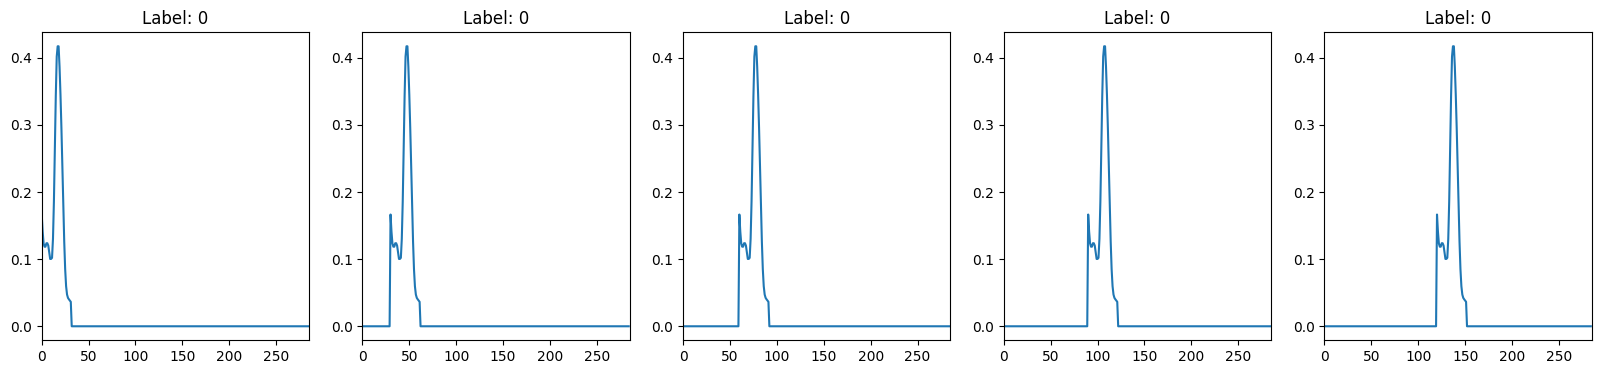

In [44]:
plot_contours(filtered_contours_aug, filtered_labels_aug, max_length)

In [45]:
print(filtered_contours_aug.shape)
print(filtered_labels_aug.shape)

(162196, 285)
(162196,)


# Augmented Contours Skewed

In [46]:
# Define the input shape
input_shape = (285,)

# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=input_shape))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               36608     
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 44929 (175.50 KB)
Trainable params: 44929 (175.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
model.fit(contours_aug, labels_aug, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
16110/16110 [==============================] - 43s 3ms/step - loss: 0.4198 - accuracy: 0.8149 - val_loss: 0.4218 - val_accuracy: 0.8143
Epoch 2/10
16110/16110 [==============================] - 45s 3ms/step - loss: 0.4133 - accuracy: 0.8183 - val_loss: 0.4187 - val_accuracy: 0.8187
Epoch 3/10
16110/16110 [==============================] - 48s 3ms/step - loss: 0.4070 - accuracy: 0.8223 - val_loss: 0.4073 - val_accuracy: 0.8224
Epoch 4/10
16110/16110 [==============================] - 49s 3ms/step - loss: 0.4020 - accuracy: 0.8248 - val_loss: 0.4036 - val_accuracy: 0.8240
Epoch 5/10
16110/16110 [==============================] - 48s 3ms/step - loss: 0.3980 - accuracy: 0.8275 - val_loss: 0.4008 - val_accuracy: 0.8254
Epoch 6/10
16110/16110 [==============================] - 48s 3ms/step - loss: 0.3943 - accuracy: 0.8290 - val_loss: 0.3979 - val_accuracy: 0.8275
Epoch 7/10
16110/16110 [==============================] - 48s 3ms/step - loss: 0.3912 - accuracy: 0.8309 - val_loss: 0

10069/10069 [==============================] - 14s 1ms/step
Accuracy:  83.49265664378206 %


array([1, 1, 1, ..., 0, 0, 0])

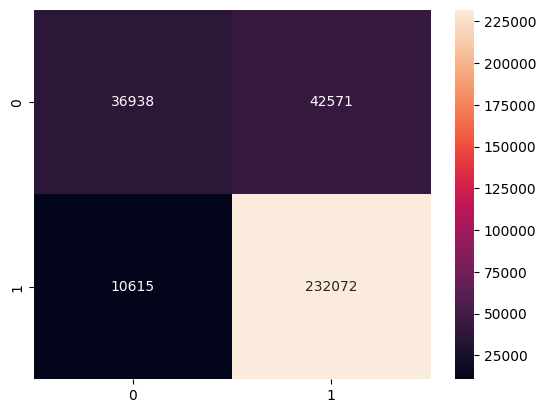

In [51]:
results(model, contours_aug, labels_aug)

# Augmented Contours Balanced

In [52]:
# Define the input shape
input_shape = (285,)

# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=input_shape))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               36608     
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 44929 (175.50 KB)
Trainable params: 44929 (175.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
model.fit(filtered_contours_aug, filtered_labels_aug, epochs=10, batch_size=8, validation_split=0.2)

Epoch 1/10
16220/16220 [==============================] - 40s 2ms/step - loss: 0.5509 - accuracy: 0.7224 - val_loss: 0.6923 - val_accuracy: 0.6490
Epoch 2/10
16220/16220 [==============================] - 38s 2ms/step - loss: 0.5128 - accuracy: 0.7535 - val_loss: 0.6046 - val_accuracy: 0.7003
Epoch 3/10
16220/16220 [==============================] - 42s 3ms/step - loss: 0.5009 - accuracy: 0.7607 - val_loss: 0.7070 - val_accuracy: 0.6505
Epoch 4/10
16220/16220 [==============================] - 42s 3ms/step - loss: 0.4938 - accuracy: 0.7636 - val_loss: 0.6822 - val_accuracy: 0.6502
Epoch 5/10
16220/16220 [==============================] - 42s 3ms/step - loss: 0.4869 - accuracy: 0.7681 - val_loss: 0.6607 - val_accuracy: 0.6701
Epoch 6/10
16220/16220 [==============================] - 42s 3ms/step - loss: 0.4815 - accuracy: 0.7703 - val_loss: 0.6035 - val_accuracy: 0.6962
Epoch 7/10
16220/16220 [==============================] - 43s 3ms/step - loss: 0.4760 - accuracy: 0.7730 - val_loss: 0

10069/10069 [==============================] - 17s 2ms/step
Accuracy:  72.42610088269252 %


array([1, 1, 1, ..., 0, 0, 0])

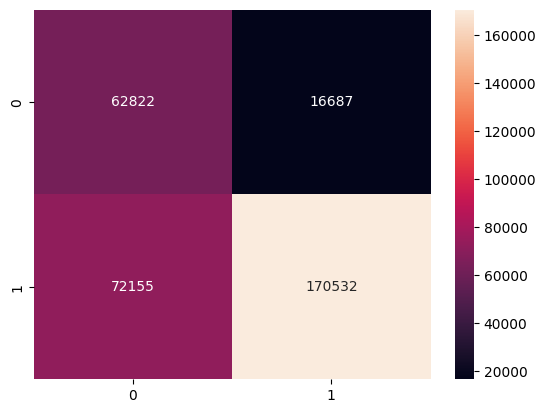

In [55]:
results(model, contours_aug, labels_aug)    

# Merging CNN and DNN

In [56]:
# Define the input shapes
input_shape1 = (138, 1)
input_shape2 = (1,)

# Define the input layers
input1 = Input(shape=input_shape1)
input2 = Input(shape=input_shape2)


In [57]:
# Define the LSTM layer
lstm_output = LSTM(128)(input1)

# Concatenate the LSTM output and the length input
concatenated = Concatenate()([lstm_output, input2])

# reduce the dimension, 128 is too high (32, 16, ...)
# dropouts

In [58]:
# Define the dense layers
dense1 = Dense(64, activation='relu')(concatenated)
dense2 = Dense(1, activation='sigmoid')(dense1)

In [59]:
# Define the model with two inputs
model = Model(inputs=[input1, input2], outputs=dense2)

In [60]:
# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 138, 1)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  66560     ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 129)                  0         ['lstm[0][0]',                
                                                                     'input_2[0][0]']         

In [61]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [62]:
ger_train_contours = ger_train["chunks"]
type(ger_train_contours)
ger_train_contours.shape

(12195,)

In [63]:
ger_train_contours = np.array(ger_train_contours)
type(ger_train_contours)

numpy.ndarray

In [64]:
ger_train_contours
ger_train_2d = np.stack(contours_train_rp)

In [65]:
# Convert the input data to TensorFlow tensors
X_tensor = tf.convert_to_tensor(ger_train_2d, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(ger_train_labels, dtype=tf.float32)

In [66]:
model.fit([ger_train_2d, lengths_train], ger_train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 138, 1), found shape=(None, 285)


# Duration - Method 1

In [67]:
# append length of contours to the end of each contour
def append_length_end(contours):
    appended_contours = []
    for contour in contours:
        appended_contours.append(np.append(contour, len(contour)))
    return np.array(appended_contours)

# append length of contours to the beginning of each contour
def append_length_start(contours):
    appended_contours = []
    for contour in contours:
        appended_contours.append(np.append(len(contour), contour))
    return np.array(appended_contours)

contours_train_rp_duration = append_length_end(contours_train_rp)
contours_test_rp_duration = append_length_end(contours_test_rp)
contours_train_lp_duration = append_length_start(contours_train_lp)
contours_test_lp_duration = append_length_start(contours_test_lp)

In [68]:
contours_train_rp_duration.shape

(12195, 286)

In [69]:
model = Sequential()
model.add(Dense(64, input_dim=max_length + 1, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [70]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(contours_train_rp_duration, ger_train["labels"], batch_size=16, epochs=50, validation_split=0.2)

Epoch 1/50
610/610 [==============================] - 4s 5ms/step - loss: 0.6160 - accuracy: 0.7440 - val_loss: 0.5603 - val_accuracy: 0.7552
Epoch 2/50
610/610 [==============================] - 3s 5ms/step - loss: 0.5384 - accuracy: 0.7558 - val_loss: 0.5683 - val_accuracy: 0.7552
Epoch 3/50
610/610 [==============================] - 3s 5ms/step - loss: 0.5227 - accuracy: 0.7558 - val_loss: 0.5113 - val_accuracy: 0.7552
Epoch 4/50
610/610 [==============================] - 3s 5ms/step - loss: 0.5145 - accuracy: 0.7558 - val_loss: 0.4976 - val_accuracy: 0.7552
Epoch 5/50
610/610 [==============================] - 3s 5ms/step - loss: 0.5059 - accuracy: 0.7559 - val_loss: 0.4953 - val_accuracy: 0.7552
Epoch 6/50
610/610 [==============================] - 3s 5ms/step - loss: 0.5020 - accuracy: 0.7557 - val_loss: 0.4887 - val_accuracy: 0.7552
Epoch 7/50
610/610 [==============================] - 4s 6ms/step - loss: 0.4951 - accuracy: 0.7558 - val_loss: 0.4867 - val_accuracy: 0.7630
Epoch 

331/331 [==============================] - 1s 3ms/step
Accuracy:  79.94897477085892 %


array([1, 0, 1, ..., 1, 1, 1])

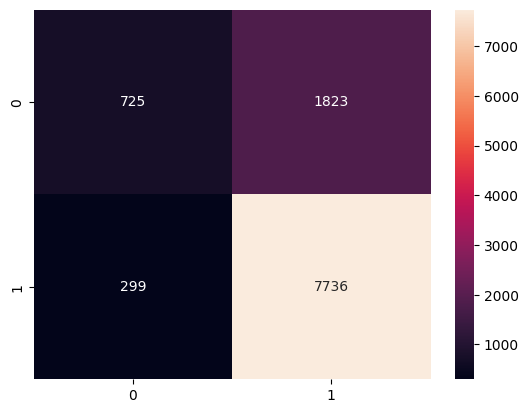

In [71]:
results(model, contours_test_rp_duration, ger_test["labels"])

In [72]:
# predict on test set
pred = model.predict(contours_test_rp_duration)
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

331/331 [==============================] - 1s 2ms/step


In [73]:
# calculate accuracy
num_correct = np.count_nonzero(ger_test_labels == pred)
num_wrong = len(ger_test_labels) - num_correct
accuracy = num_correct / len(ger_test_labels)
num_1as0 = np.count_nonzero((ger_test_labels == 1) & (pred == 0))
num_1 = np.count_nonzero(ger_test_labels == 1)
num_0as1 = np.count_nonzero((ger_test_labels == 0) & (pred == 1))
num_0 = np.count_nonzero(ger_test_labels == 0)
perc0as1 = (num_0as1 / num_0 )* 100

In [74]:
# display results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Num 1 as 0: {num_1as0} out of {num_1}")
print(f"Num 0 as 1: {num_0as1} out of {num_0}")
print(f"0 as 1 percentage: {perc0as1:.2f}%")

Accuracy: 79.95%
Num 1 as 0: 299 out of 8035
Num 0 as 1: 1823 out of 2548
0 as 1 percentage: 71.55%


In [75]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(contours_train_lp_duration, train_labels, batch_size=16, epochs=50, validation_split=0.2)

NameError: name 'train_labels' is not defined

In [76]:
# predict on test set
pred = model.predict(contours_test_lp_duration)
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

331/331 [==============================] - 1s 2ms/step


In [77]:
# calculate accuracy
num_correct = np.count_nonzero(ger_test_labels == pred)
num_wrong = len(ger_test_labels) - num_correct
accuracy = num_correct / len(ger_test_labels)
num_1as0 = np.count_nonzero((ger_test_labels == 1) & (pred == 0))
num_1 = np.count_nonzero(ger_test_labels == 1)
num_0as1 = np.count_nonzero((ger_test_labels == 0) & (pred == 1))
num_0 = np.count_nonzero(ger_test_labels == 0)
perc0as1 = (num_0as1 / num_0 )* 100

In [78]:
# display results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Num 1 as 0: {num_1as0} out of {num_1}")
print(f"Num 0 as 1: {num_0as1} out of {num_0}")
print(f"0 as 1 percentage: {perc0as1:.2f}%")

Accuracy: 75.92%
Num 1 as 0: 0 out of 8035
Num 0 as 1: 2548 out of 2548
0 as 1 percentage: 100.00%


In [79]:
contours_test_lp_duration.shape

(10583, 286)

# Duration - Method 2

In [80]:
# Define input shapes
contour_shape = (138, )
duration_shape = (1, )

# Define inputs
contour_input = Input(shape=contour_shape, name='contour_input')
duration_input = Input(shape=duration_shape, name='duration_input')

In [81]:
# Reshape contour input to 3D tensor
contour_3d = Reshape(target_shape=(contour_shape[0], 1))(contour_input)

# Define RNN layer
rnn_layer = LSTM(units=64, name='rnn')(contour_3d)

In [82]:
# Concatenate duration and RNN layer outputs
concat_layer = concatenate([rnn_layer, duration_input])

In [83]:
# Define stress label prediction layer
stress_pred = Dense(units=1, activation='sigmoid', name='stress')(concat_layer)

In [84]:
# Define model
model = Model(inputs=[contour_input, duration_input], outputs=stress_pred)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [85]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 contour_input (InputLayer)  [(None, 138)]                0         []                            
                                                                                                  
 reshape (Reshape)           (None, 138, 1)               0         ['contour_input[0][0]']       
                                                                                                  
 rnn (LSTM)                  (None, 64)                   16896     ['reshape[0][0]']             
                                                                                                  
 duration_input (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                          

In [86]:
# Train model
model.fit(x=[contours_train_rp, max_length], y=ger_train['labels'], epochs=50, batch_size=32)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'int'>", "<class 'numpy.ndarray'>"}), <class 'pandas.core.series.Series'>

In [87]:
# predict on test set
pred = model.predict([contours_test_rp, lengths_test])  
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

ValueError: in user code:

    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\abhay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 138), found shape=(None, 285)


## Class Weights
* 75% of the labels are stressed
* Hence the model is biased towards stressed data
* Half the time, the unstressed labels were predicted as stressed
* Class weights place a greater importance in getting the unstressed labels correct than the stressed labels

In [88]:
# define the model
model = Sequential()
model.add(Dense(64, input_dim=max_length, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 64)                18304     
                                                                 
 dense_29 (Dense)            (None, 128)               8320      
                                                                 
 dense_30 (Dense)            (None, 256)               33024     
                                                                 
 dense_31 (Dense)            (None, 1)                 257       
                                                                 
Total params: 59905 (234.00 KB)
Trainable params: 59905 (234.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [89]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [90]:
model.fit(
    contours_train_merged, labels_train_merged,
    batch_size=16, epochs=100, validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

Epoch 1/100
912/912 [==============================] - 3s 3ms/step - loss: 0.5633 - accuracy: 0.7321 - val_loss: 0.4869 - val_accuracy: 0.7805
Epoch 2/100
912/912 [==============================] - 2s 2ms/step - loss: 0.5299 - accuracy: 0.7605 - val_loss: 0.5890 - val_accuracy: 0.7084
Epoch 3/100
912/912 [==============================] - 2s 2ms/step - loss: 0.5136 - accuracy: 0.7792 - val_loss: 0.4702 - val_accuracy: 0.7931
Epoch 4/100
912/912 [==============================] - 2s 3ms/step - loss: 0.5086 - accuracy: 0.7840 - val_loss: 0.4773 - val_accuracy: 0.7920
Epoch 5/100
912/912 [==============================] - 2s 3ms/step - loss: 0.4997 - accuracy: 0.7865 - val_loss: 0.5401 - val_accuracy: 0.7621
Epoch 6/100
912/912 [==============================] - 2s 3ms/step - loss: 0.4992 - accuracy: 0.7833 - val_loss: 0.4676 - val_accuracy: 0.7970
Epoch 7/100
912/912 [==============================] - 2s 3ms/step - loss: 0.4941 - accuracy: 0.7888 - val_loss: 0.4927 - val_accuracy: 0.7885

In [91]:
# predict on test set
pred = model.predict(contours_test_merged)
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

143/143 [==============================] - 0s 2ms/step


In [92]:
# calculate accuracy
num_correct = np.count_nonzero(labels_test_merged == pred)
num_wrong = len(labels_test_merged) - num_correct
accuracy = (num_correct / len(labels_test_merged)) * 100

num_1as0 = np.count_nonzero((labels_test_merged == 1) & (pred == 0))
num_1 = np.count_nonzero(labels_test_merged == 1)
perc1as0 = (num_1as0 / num_1 )* 100

num_0as1 = np.count_nonzero((labels_test_merged == 0) & (pred == 1))
num_0 = np.count_nonzero(labels_test_merged == 0)
perc0as1 = (num_0as1 / num_0 )* 100

In [93]:
# display results
print(f"Accuracy: {accuracy:.2f}%")
print(f"1 as 0 percentage: {perc1as0:.2f}%")
print(f"0 as 1 percentage: {perc0as1:.2f}%")

Accuracy: 77.81%
1 as 0 percentage: 21.41%
0 as 1 percentage: 24.58%


## Capture the duration
The TimeDistributed layer is a wrapper in Keras that allows you to apply a layer to each time step of an input sequence. It is useful for processing sequential data such as time series or video frames where each time step or frame has the same structure and the same layer(s) need to be applied to each time step/frame.

In [94]:
# use time distributed layer to capture temporal information
model = Sequential()
model.add(TimeDistributed(Dense(64, input_dim=max_length, activation='relu')))
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(TimeDistributed(Dense(256, activation='relu')))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.add(Flatten())

# build the model with model.build()
model.build(input_shape=(None, 1, max_length))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 1, 64)             18304     
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 1, 128)            8320      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 1, 256)            33024     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 1, 1)              257       
 stributed)                                                      
                                                                 
 flatten (Flatten)           (None, 1)                

In [95]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
contours_train_merged_rs = np.reshape(contours_train_merged, (contours_train_merged.shape[0], 1, contours_train_merged.shape[1]))

In [96]:
model.fit(
    contours_train_merged_rs, labels_train_merged,
    batch_size=16, epochs=100, validation_split=0.2,
    callbacks=[early_stopping],
)

Epoch 1/100


912/912 [==============================] - 4s 3ms/step - loss: 0.4527 - accuracy: 0.7988 - val_loss: 0.4927 - val_accuracy: 0.7907
Epoch 2/100
912/912 [==============================] - 2s 2ms/step - loss: 0.4230 - accuracy: 0.8197 - val_loss: 0.4308 - val_accuracy: 0.8236
Epoch 3/100
912/912 [==============================] - 2s 2ms/step - loss: 0.4094 - accuracy: 0.8261 - val_loss: 0.4264 - val_accuracy: 0.8272
Epoch 4/100
912/912 [==============================] - 2s 2ms/step - loss: 0.3988 - accuracy: 0.8315 - val_loss: 0.4336 - val_accuracy: 0.8261
Epoch 5/100
912/912 [==============================] - 2s 2ms/step - loss: 0.3936 - accuracy: 0.8336 - val_loss: 0.4153 - val_accuracy: 0.8285
Epoch 6/100
912/912 [==============================] - 2s 3ms/step - loss: 0.3895 - accuracy: 0.8400 - val_loss: 0.4183 - val_accuracy: 0.8285
Epoch 7/100
912/912 [==============================] - 2s 3ms/step - loss: 0.3851 - accuracy: 0.8424 - val_loss: 0.4343 - val_accuracy: 0.8274
Epoch 8/100

In [97]:
# predict on test set
pred = model.predict(contours_test_merged.reshape((contours_test_merged.shape[0], 1, contours_test_merged.shape[1])))
# pred = model.predict(contours_test_merged)
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

143/143 [==============================] - 0s 2ms/step


In [98]:
# calculate accuracy
num_correct = np.count_nonzero(labels_test_merged == pred)
num_wrong = len(labels_test_merged) - num_correct
accuracy = (num_correct / len(labels_test_merged)) * 100

num_1as0 = np.count_nonzero((labels_test_merged == 1) & (pred == 0))
num_1 = np.count_nonzero(labels_test_merged == 1)
perc1as0 = (num_1as0 / num_1 )* 100

num_0as1 = np.count_nonzero((labels_test_merged == 0) & (pred == 1))
num_0 = np.count_nonzero(labels_test_merged == 0)
perc0as1 = (num_0as1 / num_0 )* 100

In [99]:
# display results
print(f"Accuracy: {accuracy:.2f}%")
print(f"1 as 0 percentage: {perc1as0:.2f}%")
print(f"0 as 1 percentage: {perc0as1:.2f}%")

Accuracy: 83.21%
1 as 0 percentage: 6.47%
0 as 1 percentage: 48.18%


## Capture the Duration - Class Weights

In [100]:
model.fit(
    contours_train_merged_rs, labels_train_merged,
    batch_size=16, epochs=100, validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

Epoch 1/100


912/912 [==============================] - 3s 3ms/step - loss: 0.4794 - accuracy: 0.8146 - val_loss: 0.4888 - val_accuracy: 0.7967
Epoch 2/100
912/912 [==============================] - 3s 3ms/step - loss: 0.4745 - accuracy: 0.8165 - val_loss: 0.4307 - val_accuracy: 0.8162
Epoch 3/100
912/912 [==============================] - 3s 3ms/step - loss: 0.4722 - accuracy: 0.8102 - val_loss: 0.4459 - val_accuracy: 0.8145
Epoch 4/100
912/912 [==============================] - 3s 3ms/step - loss: 0.4833 - accuracy: 0.8137 - val_loss: 0.4523 - val_accuracy: 0.8093
Epoch 5/100
912/912 [==============================] - 3s 3ms/step - loss: 0.4814 - accuracy: 0.8094 - val_loss: 0.4543 - val_accuracy: 0.7978
Epoch 6/100
912/912 [==============================] - 3s 3ms/step - loss: 0.4887 - accuracy: 0.8066 - val_loss: 0.4360 - val_accuracy: 0.8230
Epoch 7/100
912/912 [==============================] - 3s 3ms/step - loss: 0.4923 - accuracy: 0.8053 - val_loss: 0.4615 - val_accuracy: 0.8189


In [101]:
# predict on test set
pred = model.predict(contours_test_merged.reshape((contours_test_merged.shape[0], 1, contours_test_merged.shape[1])))
# pred = model.predict(contours_test_merged)
threshold = 0.5
pred[pred >= threshold] = 1
pred[pred < threshold] = 0
pred = pred.reshape(-1)

143/143 [==============================] - 0s 2ms/step


In [102]:
# calculate accuracy
num_correct = np.count_nonzero(labels_test_merged == pred)
num_wrong = len(labels_test_merged) - num_correct
accuracy = (num_correct / len(labels_test_merged)) * 100

num_1as0 = np.count_nonzero((labels_test_merged == 1) & (pred == 0))
num_1 = np.count_nonzero(labels_test_merged == 1)
perc1as0 = (num_1as0 / num_1 )* 100

num_0as1 = np.count_nonzero((labels_test_merged == 0) & (pred == 1))
num_0 = np.count_nonzero(labels_test_merged == 0)
perc0as1 = (num_0as1 / num_0 )* 100

In [103]:
# display results
print(f"Accuracy: {accuracy:.2f}%")
print(f"1 as 0 percentage: {perc1as0:.2f}%")
print(f"0 as 1 percentage: {perc0as1:.2f}%")

Accuracy: 82.42%
1 as 0 percentage: 11.96%
0 as 1 percentage: 34.69%
